In [9]:
#改变当前工作目录到谷歌云盘的路径
from google.colab import drive
drive.mount('/content/drive/')
import os
path="/content/drive/My Drive/Colab Notebooks/"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


['c_00077.png',
 'c_00080.png',
 'c_00079.png',
 'c_00078.png',
 'c_00082.png',
 'c_00081.png',
 'c_00083.png',
 'c_00085.png',
 'c_00084.png',
 'c_00086.png',
 'c_00087.png',
 'c_00088.png',
 'c_00090.png',
 'c_00089.png',
 'c_00091.png',
 'c_00092.png',
 'c_00094.png',
 'c_00093.png',
 'c_00096.png',
 'c_00095.png',
 'c_00097.png',
 'c_00098.png',
 'c_00099.png',
 'c_00100.png',
 'c_00101.png',
 'c_00102.png',
 'c_00103.png',
 'c_00104.png',
 'c_00106.png',
 'c_00105.png',
 'c_00107.png',
 'c_00109.png',
 'c_00108.png',
 'c_00110.png',
 'c_00111.png',
 'c_00112.png',
 'c_00113.png',
 'c_00116.png',
 'c_00114.png',
 'c_00115.png',
 'c_00117.png',
 'c_00118.png',
 'c_00120.png',
 'c_00119.png',
 'c_00121.png',
 'c_00122.png',
 'c_00123.png',
 'c_00126.png',
 'c_00125.png',
 'c_00124.png',
 'c_00127.png',
 'c_00128.png',
 'c_00129.png',
 'c_00130.png',
 'c_00131.png',
 'c_00132.png',
 'c_00133.png',
 'c_00136.png',
 'c_00134.png',
 'c_00135.png',
 'c_00137.png',
 'c_00138.png',
 'c_0013

In [10]:
# 加载相应包
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

torch.manual_seed(1)
np.random.seed(1)

# 超参数设置
num_epoch = 20
batch_size = 64
lr = 1e-5
latent_size = 128
hidden_size = 256
input_size = output_size = 32 * 32 * 3  # CIFAR-10是32x32的彩色图像
KL_weight = 1 #VAE的beta

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [11]:
#下载数据
train_data = datasets.CIFAR10(root="data", train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.CIFAR10(root="data", train=False, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [12]:
class Encoder(nn.Module):
    def __init__(self, input_channels, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # 批归一化
        self.conv2 = nn.Conv2d(16, hidden_size//2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_size//2)
        self.fc_mu = nn.Linear(hidden_size//2 * 32 * 32, latent_size)
        self.fc_sigma = nn.Linear(hidden_size//2 * 32 * 32, latent_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        sigma = self.fc_sigma(x)
        return mu, sigma

class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_size, hidden_size * 32 * 32)
        self.deconv1 = nn.ConvTranspose2d(hidden_size, 16, kernel_size=3, padding=1)  # 反卷积层
        self.deconv2 = nn.ConvTranspose2d(16, output_channels, kernel_size=3, padding=1)  # 反卷积层

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), hidden_size, 32, 32)
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))  # 确保输出在[0, 1]范围内
        return x


class VAE(nn.Module):
    def __init__(self, input_channels, output_channels, latent_size, hidden_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_channels, hidden_size, latent_size)
        self.decoder = Decoder(latent_size, hidden_size, output_channels)

    def forward(self, x):
        mu, sigma = self.encoder(x)
        eps = torch.randn_like(sigma)
        z = mu + eps * sigma
        re_x = self.decoder(z)
        return re_x, mu, sigma

input_channels = 3
output_channels = 3
model = VAE(input_channels, output_channels, latent_size, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
#交叉熵
loss_BCE = torch.nn.BCELoss(reduction = 'sum')
#均方误差
loss_MSE = torch.nn.MSELoss(reduction = 'sum')
#KL散度，衡量正态分布(mu,sigma)与正态分布(0,1)的差异
loss_KLD = lambda mu,sigma: -0.5 * torch.sum(1 + torch.log(sigma**2) - mu.pow(2) - sigma**2)


In [13]:
# 训练
model.train()
for epoch in range(num_epoch):
    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        re_images, mu, sigma = model(images)

        loss_re = loss_MSE(re_images, images)
        loss_norm = loss_KLD(mu, sigma)
        loss = loss_re + KL_weight * loss_norm

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}")



Epoch [1/20], Loss: 2344.4858
Epoch [2/20], Loss: 2264.0964
Epoch [3/20], Loss: 1962.9958
Epoch [4/20], Loss: 1729.0480
Epoch [5/20], Loss: 1778.2224
Epoch [6/20], Loss: 1518.7017
Epoch [7/20], Loss: 1590.4102
Epoch [8/20], Loss: 1849.1534
Epoch [9/20], Loss: 1587.8677
Epoch [10/20], Loss: 1497.5050
Epoch [11/20], Loss: 1538.3999
Epoch [12/20], Loss: 1332.2346
Epoch [13/20], Loss: 1437.6436
Epoch [14/20], Loss: 1403.5757
Epoch [15/20], Loss: 1403.6213
Epoch [16/20], Loss: 1535.8262
Epoch [17/20], Loss: 1213.6221
Epoch [18/20], Loss: 1294.5813
Epoch [19/20], Loss: 1247.4724
Epoch [20/20], Loss: 1183.6906
Epoch [1/20], Loss: 2344.5217
Epoch [2/20], Loss: 2264.0867
Epoch [3/20], Loss: 1963.0341
Epoch [4/20], Loss: 1729.0034
Epoch [5/20], Loss: 1778.2362
Epoch [6/20], Loss: 1518.6945
Epoch [7/20], Loss: 1590.3201
Epoch [8/20], Loss: 1849.1538
Epoch [9/20], Loss: 1587.9286
Epoch [10/20], Loss: 1497.6589
Epoch [11/20], Loss: 1538.5208
Epoch [12/20], Loss: 1332.2367
Epoch [13/20], Loss: 1437.

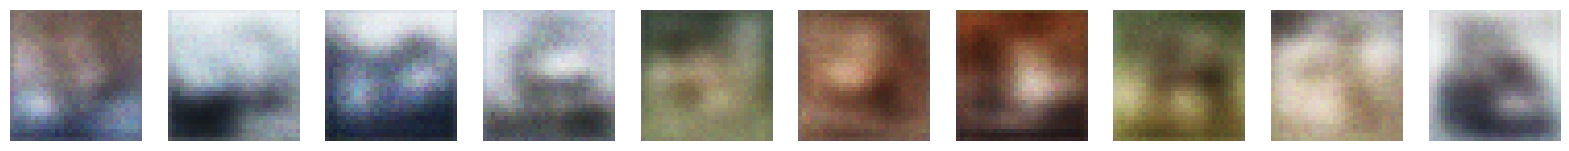

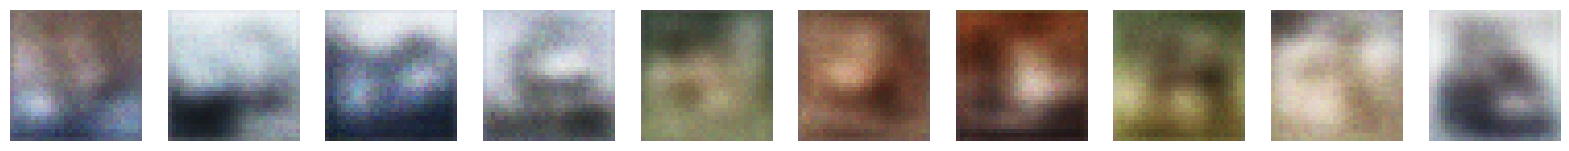

In [14]:
import matplotlib.pyplot as plt
import torchvision

dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images[:10].to(device)


with torch.no_grad():
    images_flattened = images.view(-1, input_size)
    reconstructed, _, _ = model(images)

reconstructed = reconstructed.view(10, 3, 32, 32)
images = images.view(10, 3, 32, 32)

fig, axs = plt.subplots(1, 10, figsize=(20, 4))

for i in range(10):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img_reconstructed = reconstructed[i].permute(1, 2, 0).cpu().numpy()

    img = np.clip(img, 0, 1)
    img_reconstructed = np.clip(img_reconstructed, 0, 1)

    # axs[i].imshow(img)
    # axs[i].axis('off')

    axs[i].imshow(img_reconstructed)
    axs[i].axis('off')



plt.show()


In [15]:
#生成图片并下载
import os
from PIL import Image
import torch
import numpy as np

directory = '/content/drive/My Drive/vae_cifar10_1_images/'
if not os.path.exists(directory):
    os.makedirs(directory)

num_samples = 1000
device = 'cuda'
latent_size = 128
latent_vectors = torch.randn(num_samples, latent_size).to(device)

with torch.no_grad():
    generated_images = model.decoder(latent_vectors).cpu()
    generated_images = generated_images.view(num_samples, 3, 32, 32)

for i, image in enumerate(generated_images):
    image = image.permute(1, 2, 0) * 255.0
    pil_image = Image.fromarray(image.numpy().astype(np.uint8))
    pil_image.save(f'/content/drive/My Drive/vae_cifar10_1_images/image_{i:05d}.png')
